# Compare models to select the best hyperparameters
This tutorial will review AMPL functions for visualizing the results of a hyperparameter search in order to find the optimal hyperparameters for your model.

After performing a hyperparameter search, it is prudent to examine each hyperparameter in order to determine the best combination before training a production model with all of the data. Additionally, it is good to explore multiple performance metrics and visualize the predictions instead of relying solely on metrics.

For the purposes of this tutorial, I simply ran `tutorial 6` with different parameters such as those outlined **[here](https://github.com/ATOMScience-org/AMPL#hyperparameter-optimization)** to get enough models for comparison. Specifically, I created additional NN and XGBoost models as well as using fingerprint and scaffold splits. If you don't want to run that many models, you can use the result_df saved here: `dataset/07_expanded_perf_results.csv`.

## Import packages

In [2]:
from atomsci.ddm.pipeline import compare_models as cm
from atomsci.ddm.pipeline import hyper_perf_plots as hpp
from atomsci.ddm.pipeline import perf_plots as pp
import pandas as pd

# ignore warnings in tutorials
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

## Get model results and filter
First we pull the results of the hyperparameter search into a dataframe. In `tutorial 6` we used `get_filesystem_perf_results()` which packs hyperparameters in a dict in the column `model_parameters_dict`. Here we use the individual hyperparameter columns to create visualizations.  

In [3]:
result_df=cm.get_filesystem_perf_results(result_dir='tmp_mw_kcna3_rdkit_raw/', pred_type='regression')

# result_df=pd.read_csv('dataset/07_expanded_perf_results.csv', index_col=0)
result_df=result_df.sort_values('best_valid_r2_score', ascending=False)
result_df.head(2)

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,...,rf_max_depth,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
63,b5d13c11-87ba-4941-90b9-eac8c184e90f,tmp_kcna3_rdkit_raw/curated_kcna3_ic50_model_b...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,rdkit_raw,scaffold,r2,normalization,0.732181,...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 69, ""rf_max_depth"": 22, ""rf_...",{}
11,77845fea-3d50-4bc3-bb5f-cc51c661a77d,tmp_kcna3_rdkit_raw/curated_kcna3_ic50_model_7...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,rdkit_raw,scaffold,r2,normalization,0.730707,...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 91, ""rf_max_depth"": 29, ""rf_...",{}


Often, certain random combinations of hyperparameters result in terribly performing models. Here we will filter those out so they don't affect the plots.

In [4]:
result_df.best_valid_r2_score.describe()

count    3.630000e+02
mean    -6.786822e+59
std      1.293063e+61
min     -2.463616e+62
25%     -1.653638e-01
50%      6.708696e-01
75%      7.098506e-01
max      7.321813e-01
Name: best_valid_r2_score, dtype: float64

In [5]:
# filter out objectively bad performing models
result_df=result_df[result_df.best_valid_r2_score>0]
result_df.shape

(219, 34)

In [6]:
result_df.best_valid_r2_score.describe()

count    219.000000
mean       0.650706
std        0.162093
min        0.002183
25%        0.685875
50%        0.703742
75%        0.716906
max        0.732181
Name: best_valid_r2_score, dtype: float64

## Visualize hyperparameters
There are several plotting functions in the `hyper_perf_plots` module that help visualize the different combinations of features for each type of model.

#### Examine overall scores
`plot_train_valid_test_scores()` gives a quick snapshot of your overall model performance. You can see if you overfitted and get a sense of whether your partitions are a good representation of future performance. Because the splitter can have a drastic effect on model performance, these plots are also separated by split type.

Here we see that the validation set r2_scores are pretty consistently lower than the test scores due to the nature of scaffold splitting. This might be a red flag that should be investigated further.

**explain scaffold split better**

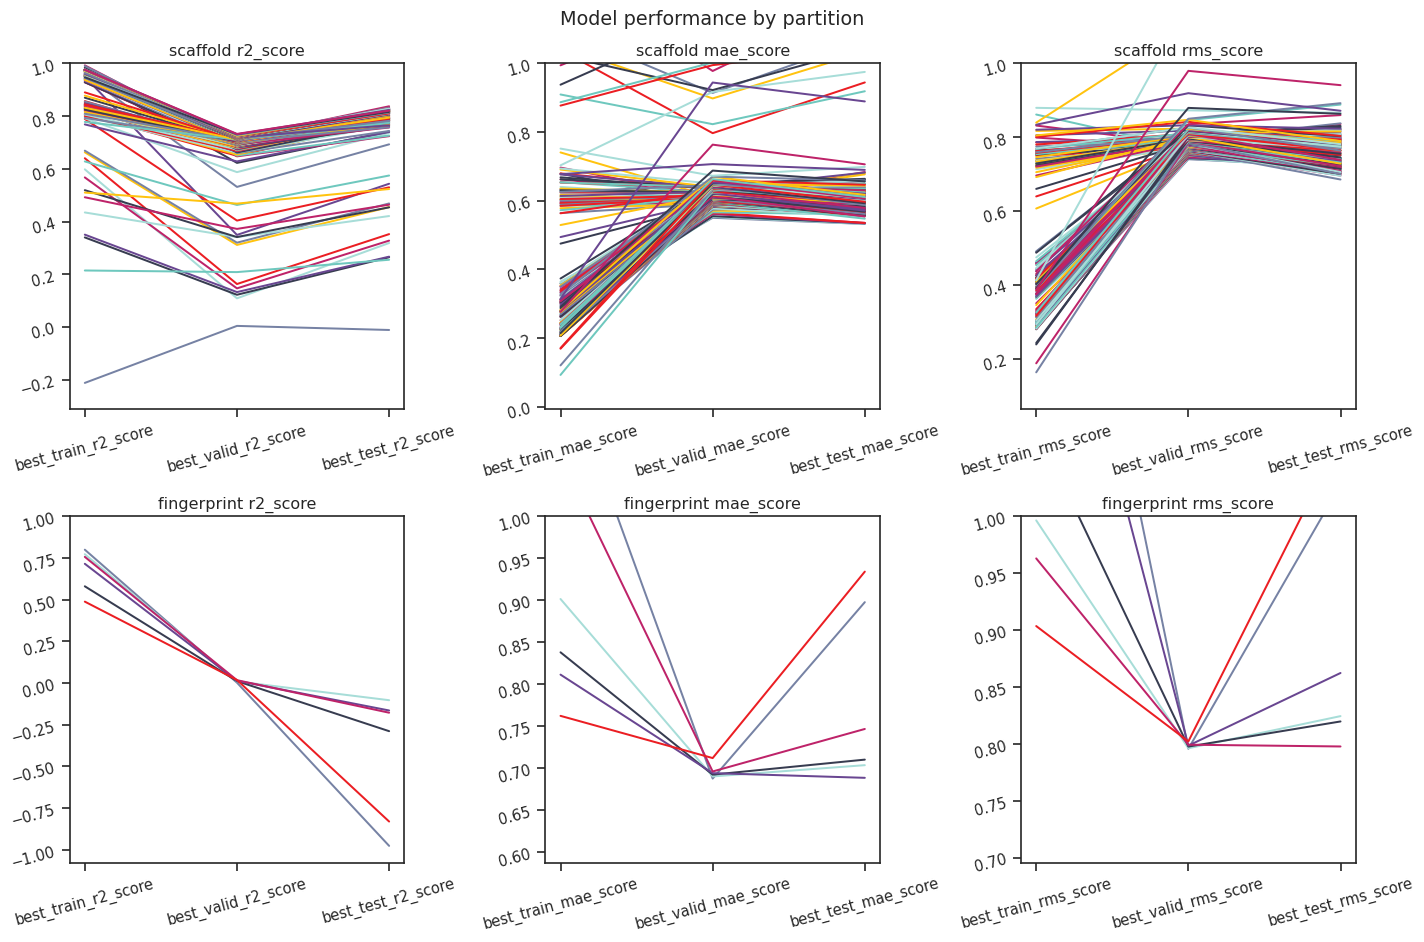

In [7]:
hpp.plot_train_valid_test_scores(result_df, prediction_type='regression')

#### Examine splits

`plot_split_perf()` plots the performance of each split type, separated by feature type, for each performance metric. 

We can see that fingerprint splits perform much worse than scaffold splits for this dataset, but ECFP and RDKit featurizers perform about equally. Interestingly, the difference between fingerprint and scaffold model performance is not observed as strongly for the RMSE score.

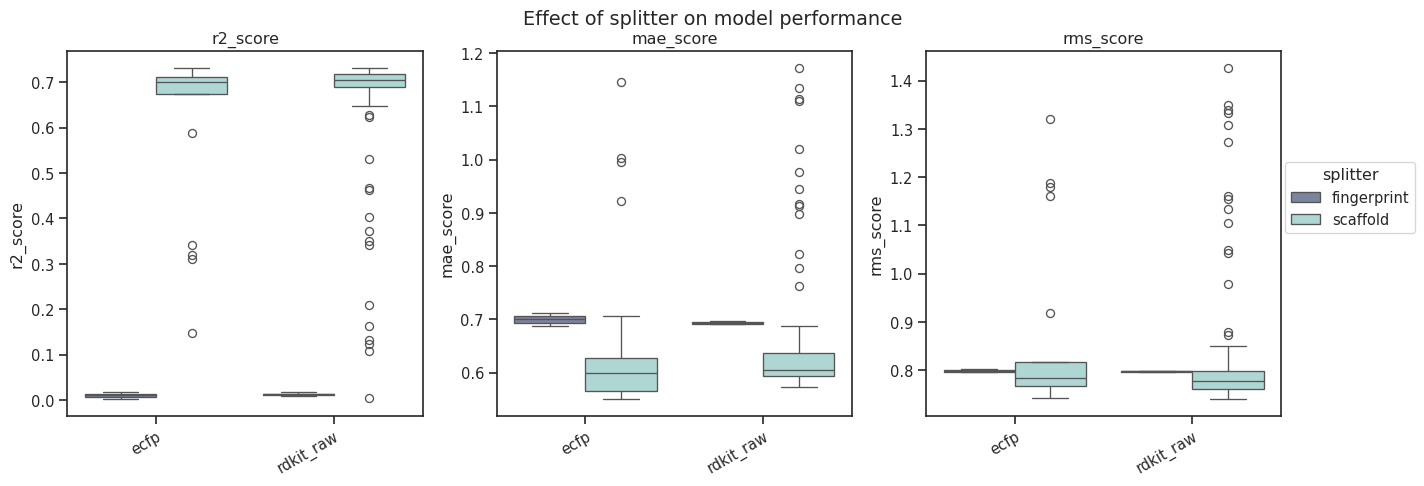

In [8]:
import importlib
importlib.reload(hpp)
hpp.plot_split_perf(result_df, subset='valid')

#### General model features
We also want to understand general hyperparameters like model type and feature type and their effect on performance. We can use `plot_hyper_perf()` with `model_type='general'` as a shortcut to visualize these. 

We can see that random forests perform the best and RDKit features perform better than ECFP. Additionally, the random forest and XGBoost models are very consistent while there is a lot of variability in the NN model performance.

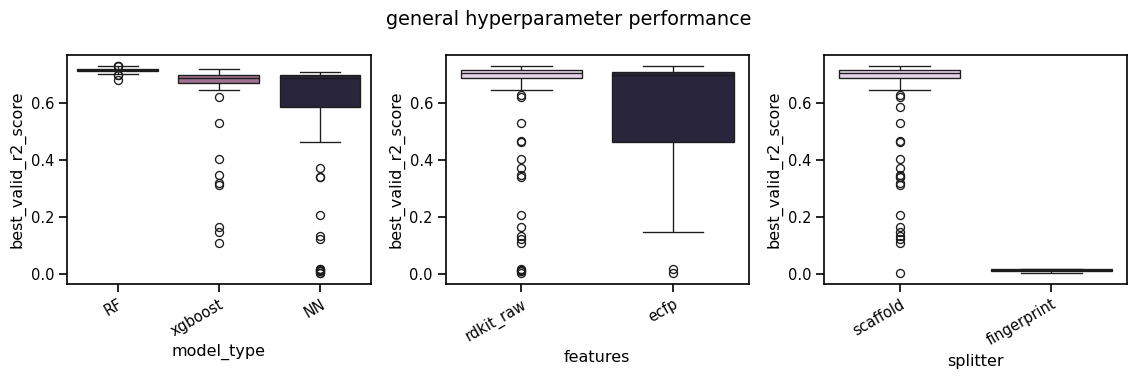

In [9]:
hpp.plot_hyper_perf(result_df)

#### RF-specific hyperparameters
We can also use `plot_hyper_perf()` to visualize model-specific hyperparameters. In this case we examine random forest models because they perform the best for this dataset.

**add explanation of results here**

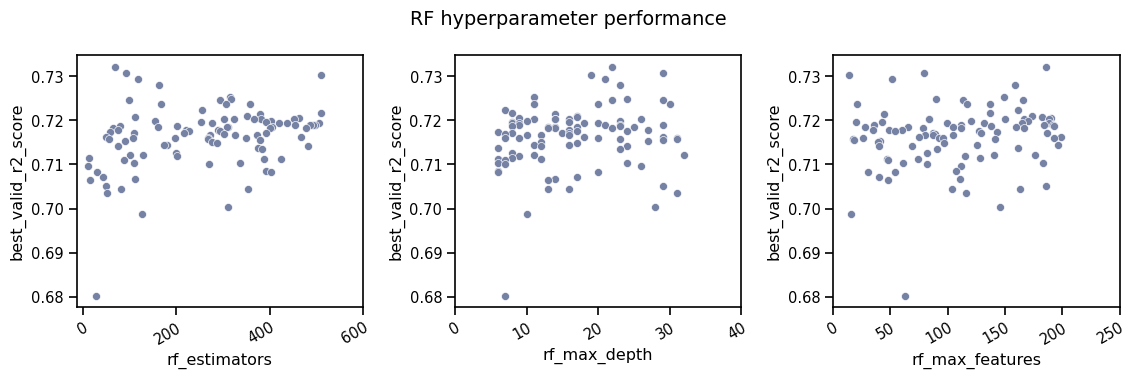

In [10]:
importlib.reload(hpp)
hpp.plot_hyper_perf(result_df, model_type='RF', subset='valid', scoretype='r2_score')

We can quickly get a list of scores to plot with `get_score_types()`.

In [11]:
hpp.get_score_types()

Classification metrics:  ['roc_auc_score', 'prc_auc_score', 'precision', 'recall_score', 'npv', 'accuracy_score', 'kappa', 'matthews_cc', 'bal_accuracy']
Regression metrics:  ['r2_score', 'mae_score', 'rms_score']


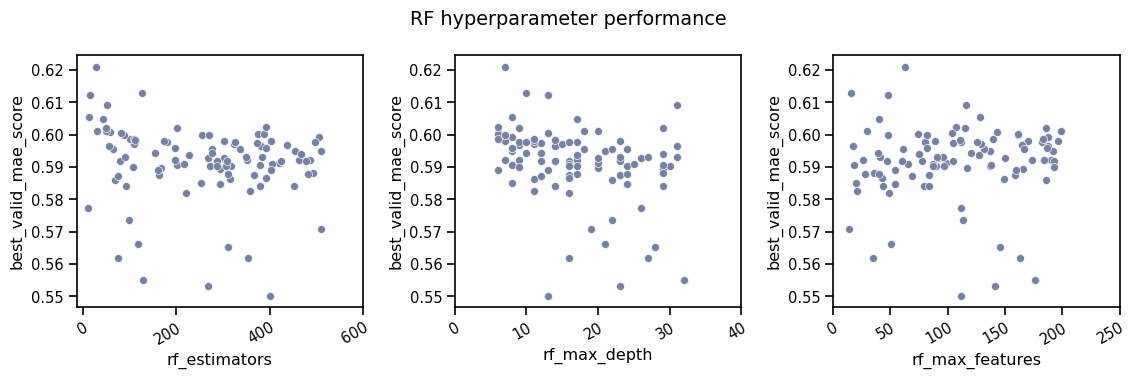

In [12]:
hpp.plot_hyper_perf(result_df, model_type='RF', subset='valid', scoretype='mae_score')

#### Combined RF plot
Combining different features for a model type can often illuminate helpful trends in the data. `plot_rf_perf()` creates a scatter plot to achieve this. There is also a verson for NN and XGboost models that review some of the top hyperparameters there.

For RF, the number of trees/max features per node is combined on the x-axis and the score on the y-axis. It is colored by max_depth per tree. Here we can see a clear trend that for a given number of trees, increasing features per node results in decreasing performance. It is most clear in the test subset. There is no obvious trend with max_depth per tree.

**explain or update these plots**

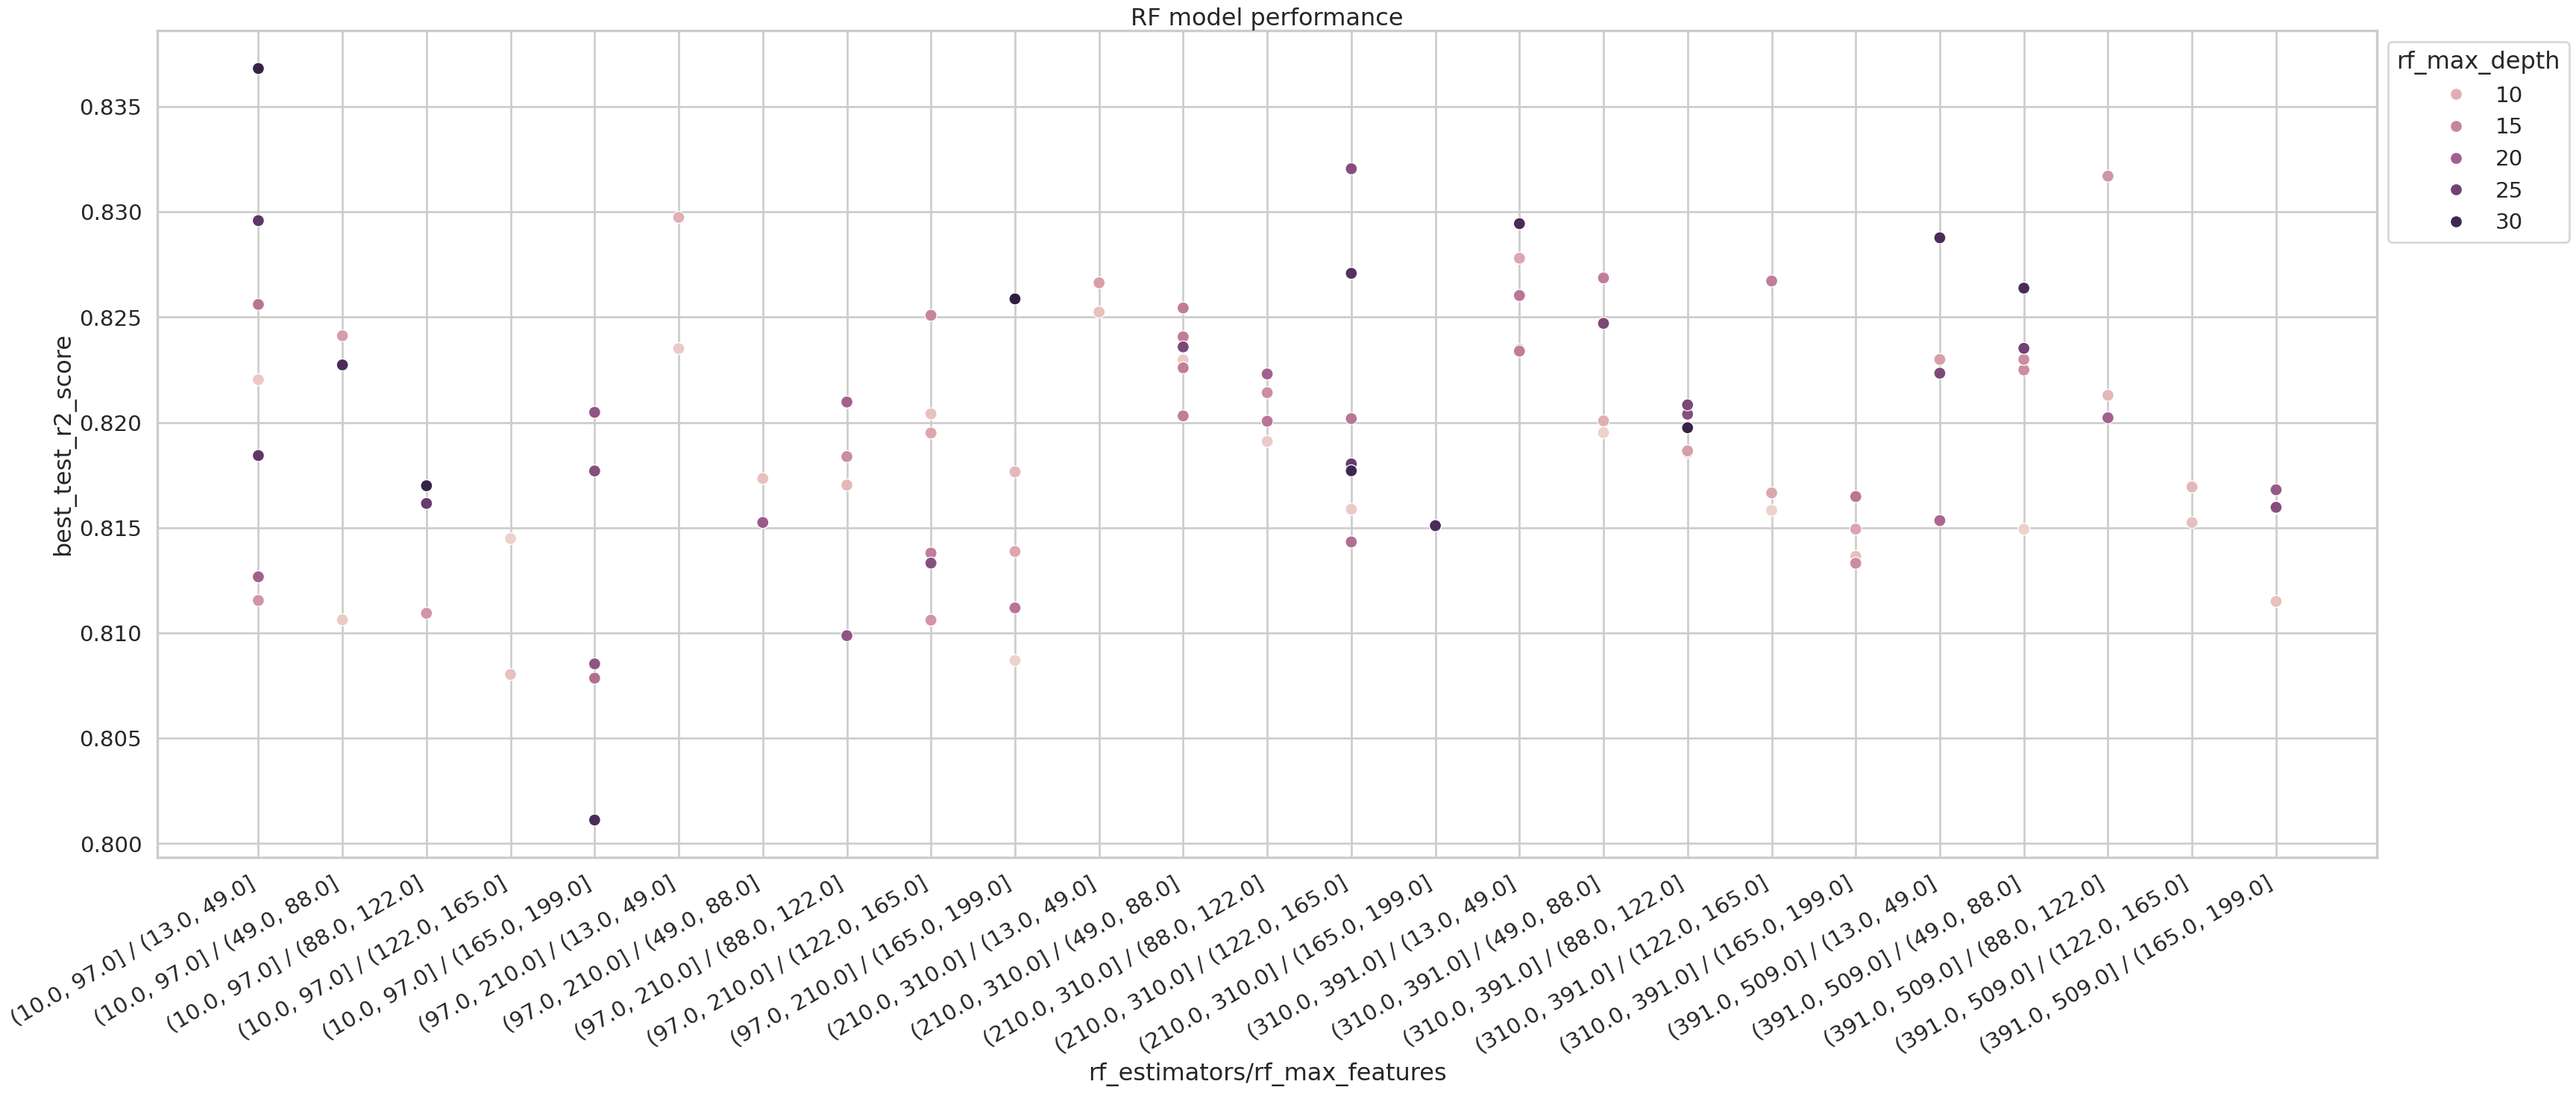

In [13]:
hpp.plot_rf_perf(result_df, scoretype='r2_score', subset='test')

While the top performing model comes from a small number of trees and a small number of features per node, we can see a lot of variability in models with these features, so it may not perform as well as we like. The second-best performing model may also be worth looking at. 

Overall, the models seem to improve as the number of trees increases to about 200, and then level out. Higher depth trees >20 seem to perform better on average. There does not seem to be a clear trend in how the number of features per node affects the model performance.

### NN visualization
When visualizing hyperparameters of NN models in this case, it is slightly hard to see important trends because there is a large variance in their model performance. To avoid this, we use `plot_hyper_perf()` with a subsetted dataframe. 

**explain 0.5 cutoff**

**plot LR with log scale**

**add interpretation**

**change num_nodes to num_weights**

product of layer sizes plus number of nodes in first layer

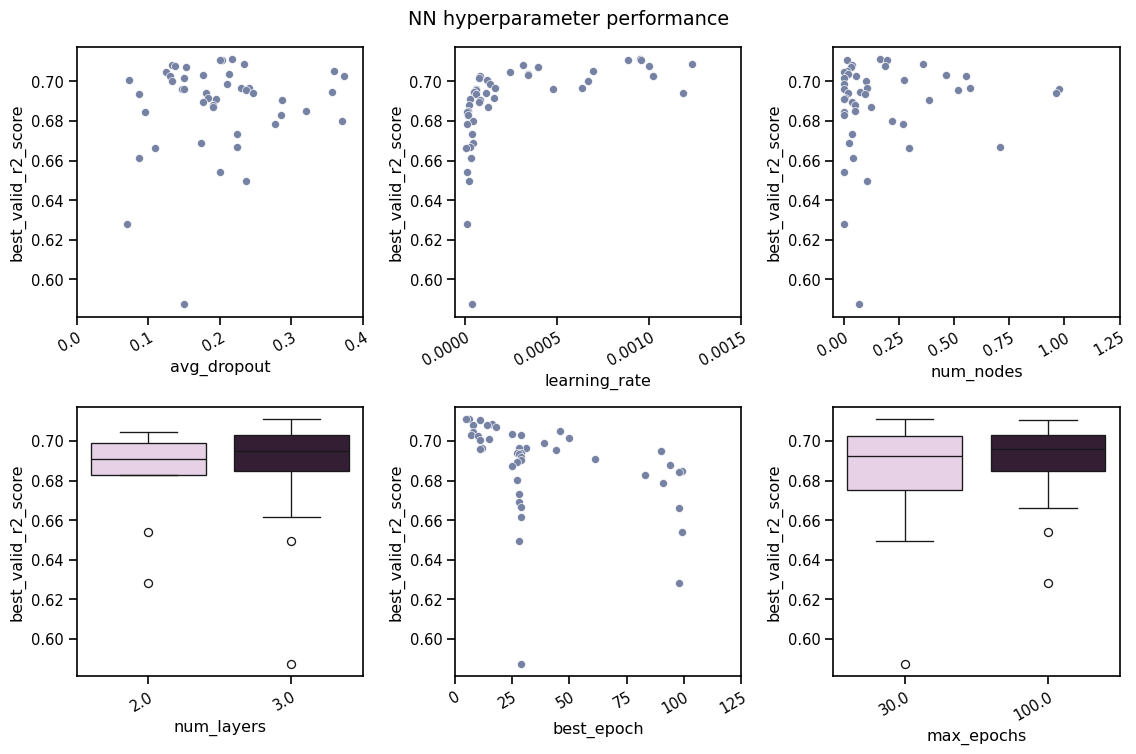

In [14]:
hpp.plot_hyper_perf(result_df[result_df.best_valid_r2_score>0.5], model_type='NN')

With `plot_nn_perf()` we can see varying trends for learning rate depending on the size of the network, which is encapsulated in num_nodes (the product of layer sizes). In medium sized networks, it appears that testing larger learning rates might improve the model metrics, since they have not plateaued. But the smallest and largest networks appear to have plateaued, indicating that the best learning rate is within the range of values that have been tried so far.

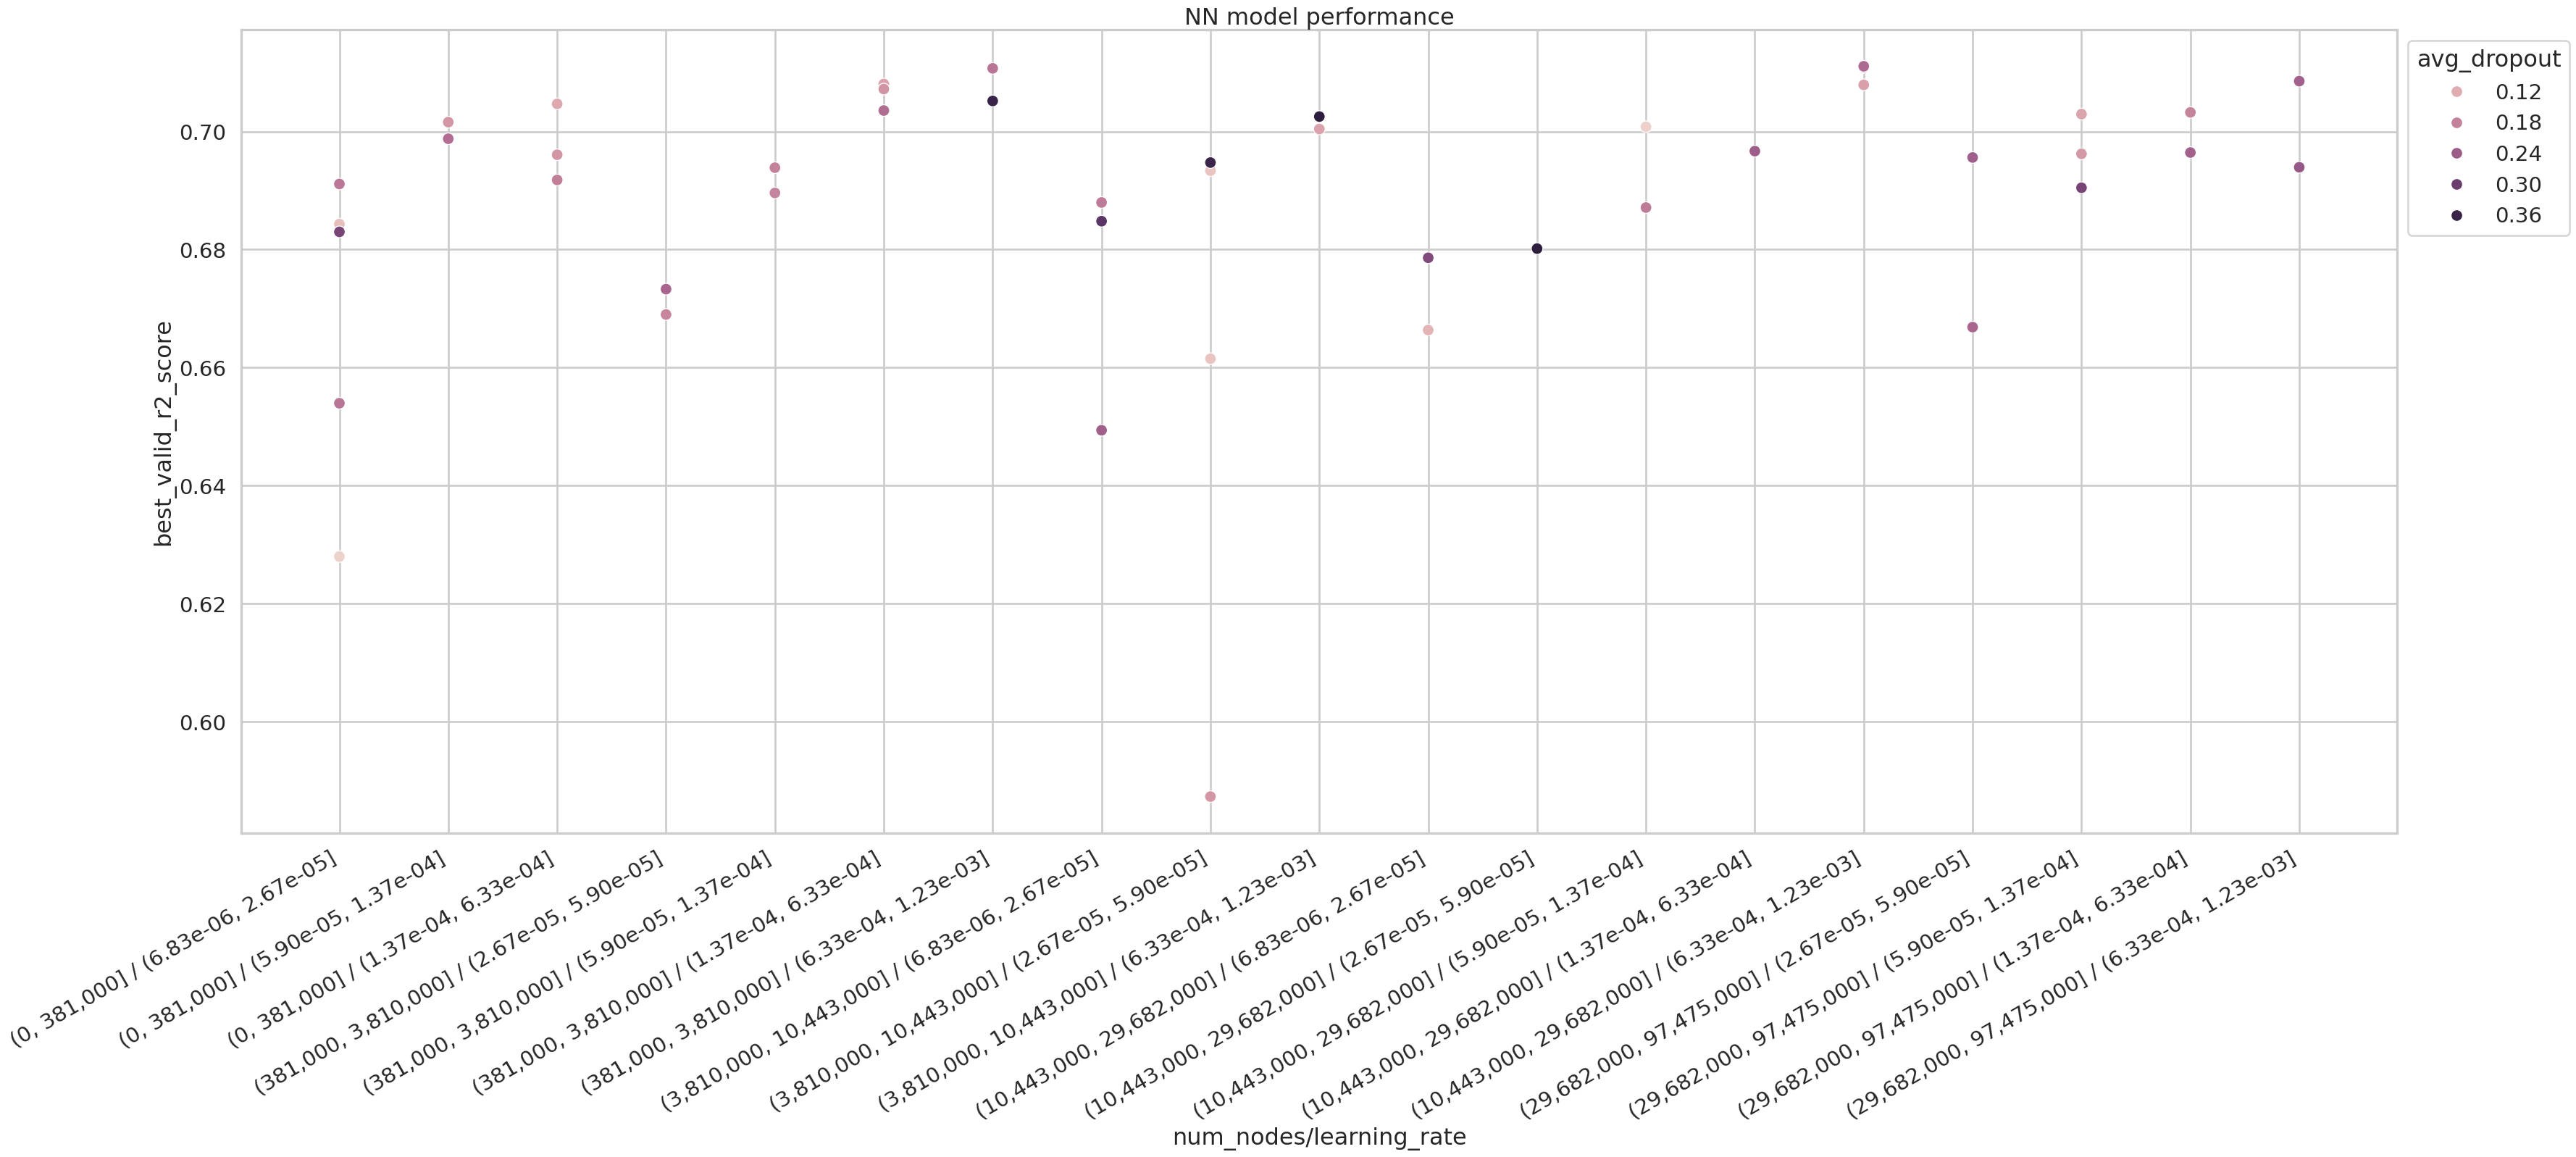

In [15]:
hpp.plot_nn_perf(result_df[result_df.best_valid_r2_score>0.5], subset='valid')

### XGBoost visualization
Using `plot_xg_perf()`, we can see that `xgb_learning_rate` should be between 0.025 and 0.5, after which the performance starts to deteriorate. There's no clear trend for `xgb_gamma` except maybe that the highest values result in worse performance.

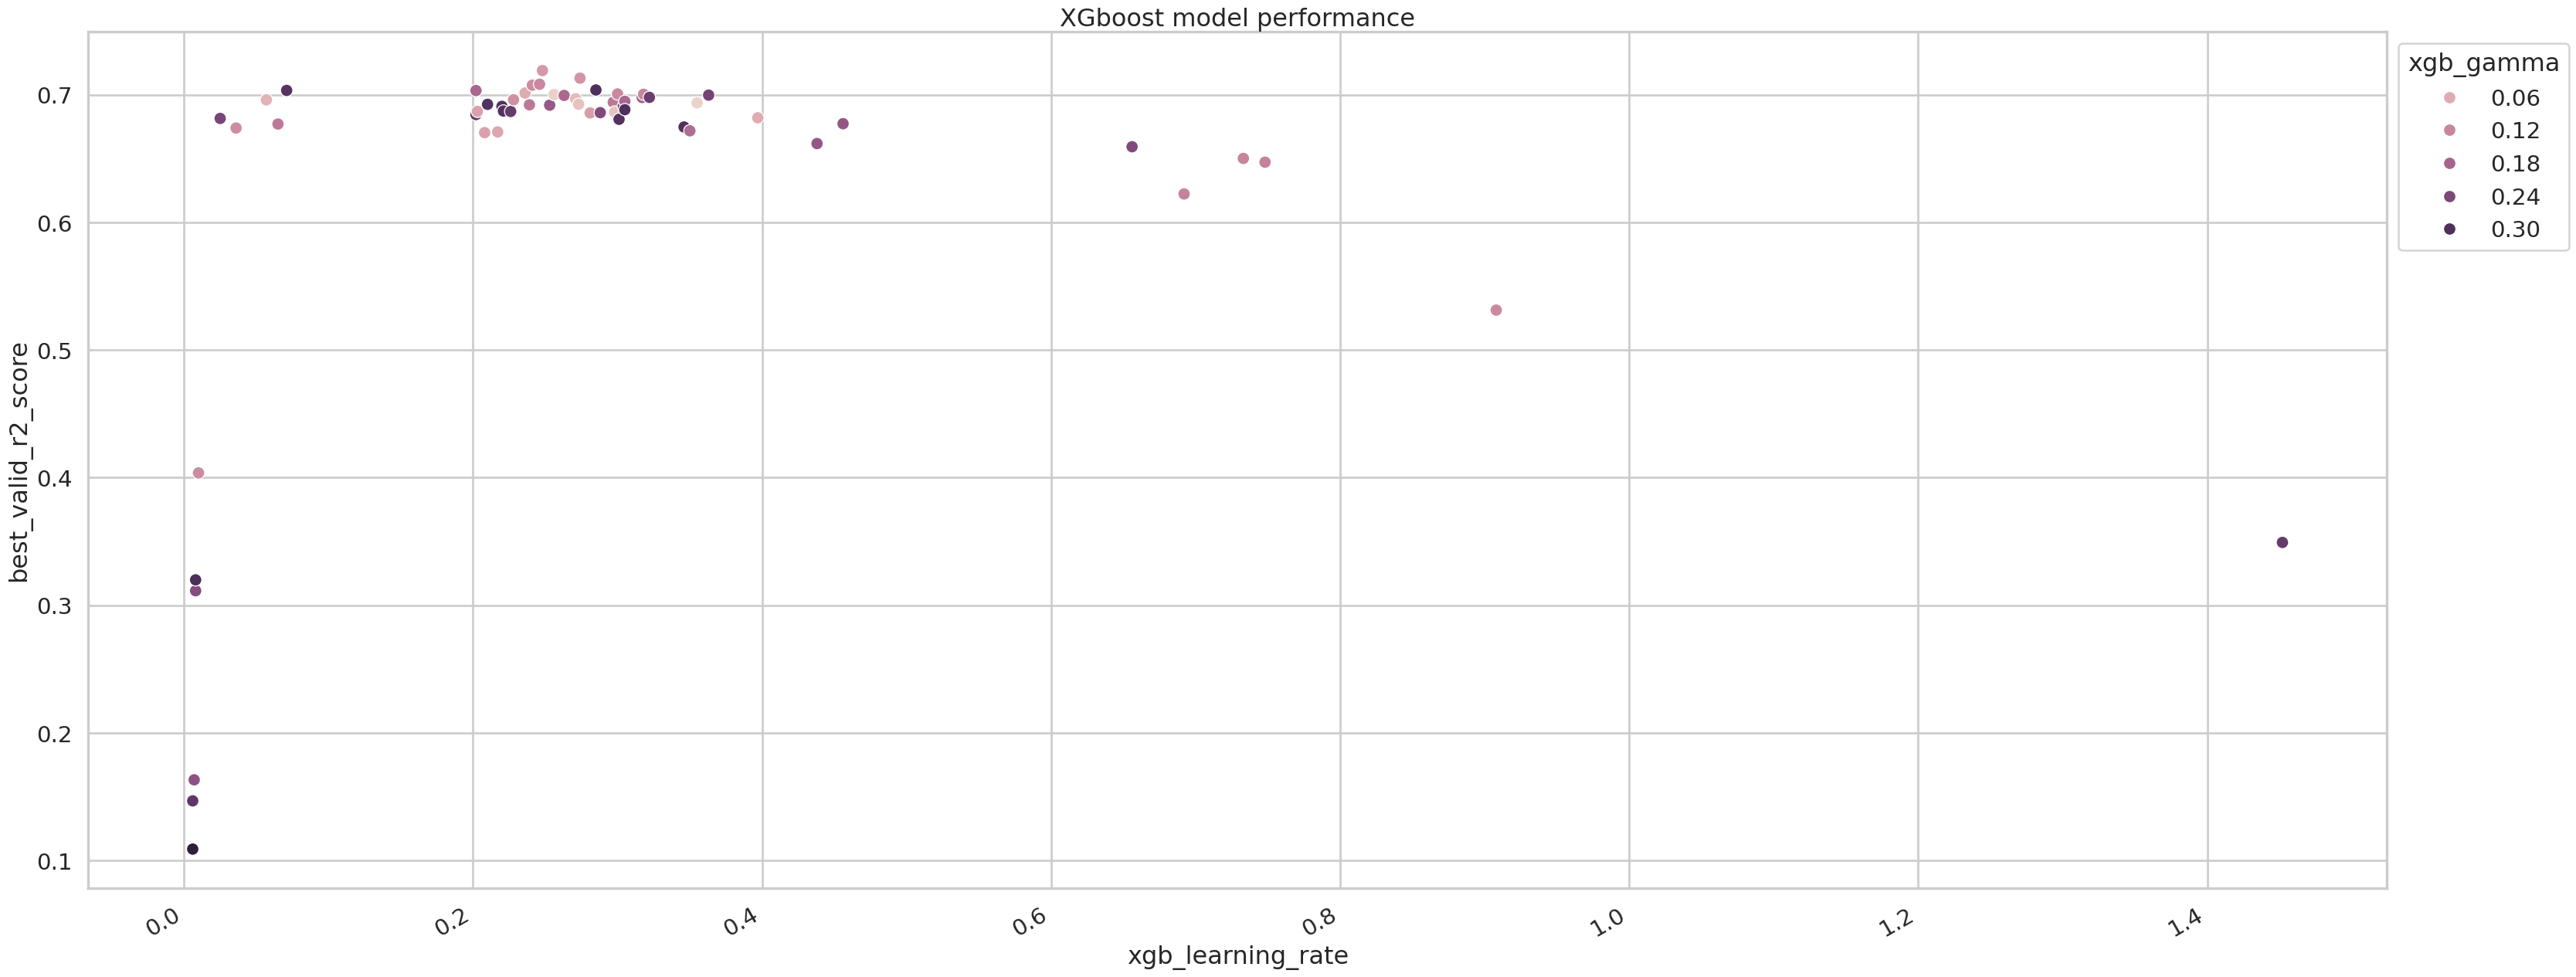

In [16]:
hpp.plot_xg_perf(result_df)

## Evaluation of a single model

After calling `compare_models.get_filesystem_perf_results()`, the dataframe can be sorted according to the score you care about. The column `model_parameters_dict` contains hyperparameters used for the best model. We can visualize this model using `perf_plots.plot_pred_vs_actual_from_file()`.

Note: not all scores should be maximized. For example, `mae_score` or `rms_score` should be minimized instead.

In [17]:
winnertype='best_valid_r2_score'
result_df=cm.get_filesystem_perf_results(result_dir='tmp_kcna3_rdkit_raw/', pred_type='regression')
result_df=result_df.sort_values(winnertype, ascending=False)

Found data for 373 models under tmp_kcna3_rdkit_raw/


In [18]:
result_df.iloc[0].best_valid_r2_score

0.7321812994387524

As discussed above, we can see that the best scoring model has less than 200 trees and the max_depth is more than 20.

In [19]:
result_df.iloc[0].model_parameters_dict

'{"rf_estimators": 69, "rf_max_depth": 22, "rf_max_features": 186}'

2024-02-02 16:16:07,822 tmp_kcna3_rdkit_raw/curated_kcna3_ic50_model_b5d13c11-87ba-4941-90b9-eac8c184e90f.tar.gz, 1.6.0
2024-02-02 16:16:07,822 Version compatible check: tmp_kcna3_rdkit_raw/curated_kcna3_ic50_model_b5d13c11-87ba-4941-90b9-eac8c184e90f.tar.gz version = "1.6", AMPL version = "1.6"
2024-02-02 16:16:07,840 ['ampl_version', 'time_generated', 'time_built', 'dataset_hash', 'dataset_metadata', 'training_metrics'] are not part of the accepted list of parameters and will be ignored
2024-02-02 16:16:07,848 Created a dataset hash '389b161b7a4eb2304323a7dfddacfacc' from dataset_key '/home/apaulson/repos/AMPL_umbrella/AMPL/atomsci/ddm/examples/tutorials2023/dataset/curated_kcna3_ic50.csv'
2024-02-02 16:16:07,853 Reading descriptor spec table from /home/apaulson/repos/AMPL_umbrella/AMPL/atomsci/ddm/data/descriptor_sets_sources_by_descr_type.csv
2024-02-02 16:16:07,855 Featurization = ComputedDescriptorFeaturization with rdkit_raw descriptors


num_model_tasks is deprecated and its value is ignored.


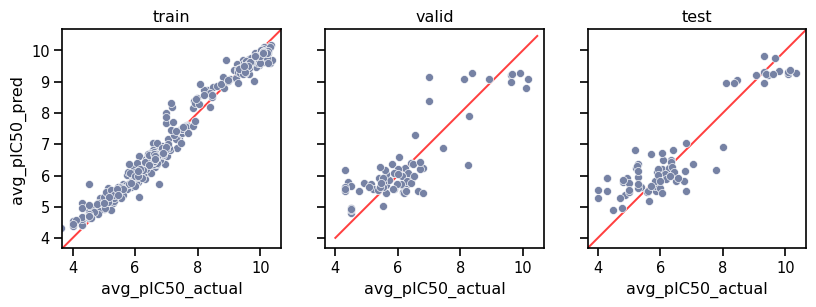

In [20]:
# plot best model, an RF
model_path=result_df.iloc[0].model_path
pp.plot_pred_vs_actual_from_file(model_path)

The best NN model does particularly bad at modeling this bimodal data, and predicts all the most potent compounds at the same pIC50.

2024-02-02 16:16:11,859 tmp_kcna3_rdkit_raw/curated_kcna3_ic50_model_0c62fd73-f4fa-4d6a-9bd1-d4a7b1c51373.tar.gz, 1.6.0
2024-02-02 16:16:11,860 Version compatible check: tmp_kcna3_rdkit_raw/curated_kcna3_ic50_model_0c62fd73-f4fa-4d6a-9bd1-d4a7b1c51373.tar.gz version = "1.6", AMPL version = "1.6"


num_model_tasks is deprecated and its value is ignored.
['/tmp/tmpnr38l3rl/best_model/checkpoint1.pt']
/tmp/tmpnr38l3rl/best_model/checkpoint1.pt

Best valid r2 score:  0.7110453299324039

Model Parameters:  {"best_epoch": 6, "dropouts": [0.36715878841381605, 0.2052819751609195, 0.06983472478406542], "layer_sizes": [278, 152, 383], "learning_rate": 0.00095225992339111, "max_epochs": 30} 



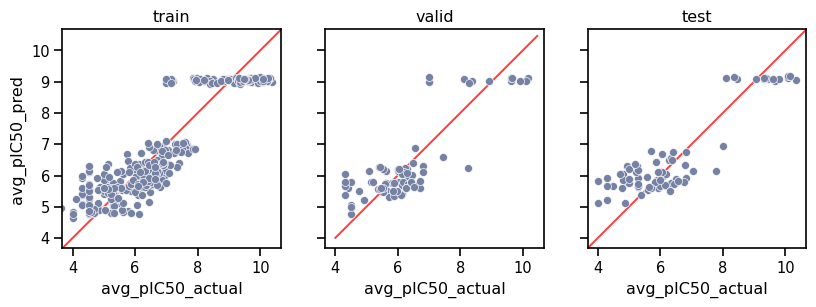

In [21]:
# plot best NN model
model_path=result_df[result_df.model_type=='NN'].iloc[0].model_path
pp.plot_pred_vs_actual_from_file(model_path)
print('\nBest valid r2 score: ',result_df[result_df.model_type=='NN'].iloc[0].best_valid_r2_score)
print('\nModel Parameters: ',result_df[result_df.model_type=='NN'].iloc[0].model_parameters_dict,'\n')

> **Note** *Be wary of selecting models only based on their performance metrics! As we can see, this NN does poorly even though the r2_score is fairly high - nearly equal to the xgboost model.*

The best XGBoosted model looks similar to the RF model. While the less potent compounds' predictions are slightly further away from the identity line in some cases, the most potent compounds look like they might be predicted more accurately compared to the RF model. 

2024-02-14 13:59:59,621 tmp_kcna3_rdkit_raw/curated_kcna3_ic50_model_16c24a74-bcb9-4d17-98fb-e0e822edb992.tar.gz, 1.6.0
2024-02-14 13:59:59,622 Version compatible check: tmp_kcna3_rdkit_raw/curated_kcna3_ic50_model_16c24a74-bcb9-4d17-98fb-e0e822edb992.tar.gz version = "1.6", AMPL version = "1.6"


num_model_tasks is deprecated and its value is ignored.

Best valid r2 score:  0.7189454930042954

Model Parameters:  {"xgb_gamma": 0.08889198545098555, "xgb_learning_rate": 0.24825895007910562} 



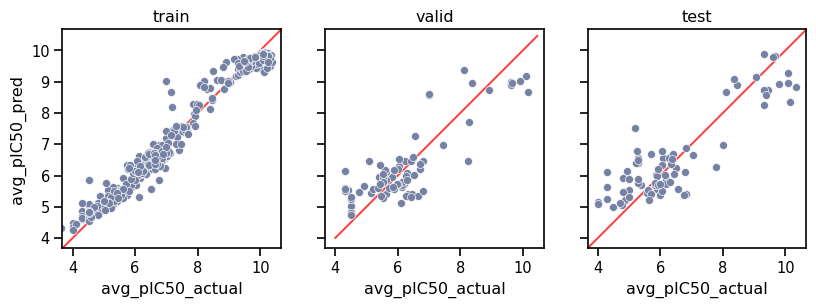

In [23]:
# plot best xgboost model
model_path=result_df[result_df.model_type=='xgboost'].iloc[0].model_path
pp.plot_pred_vs_actual_from_file(model_path)
print('\nBest valid r2 score: ',result_df[result_df.model_type=='xgboost'].iloc[0].best_valid_r2_score)
print('\nModel Parameters: ',result_df[result_df.model_type=='xgboost'].iloc[0].model_parameters_dict,'\n')

#### next tutorial
use best RF model by validation and retrain with production flag